**Package Imports**

In [1]:
import numpy      as np
import pandas     as pd
import matplotlib.pyplot as plt
import seaborn    as sns
from   zipfile    import ZipFile
from   datetime   import datetime
import random
import re
import time 

from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score

from bayes_opt               import BayesianOptimization
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics         import accuracy_score, make_scorer, roc_auc_score, log_loss
from sklearn.utils           import class_weight
from xgboost                 import XGBClassifier

import xgboost as xgb

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files = files.upload()

Saving kaggle.json to kaggle (1).json


In [4]:
! mkdir ~/.kaggle          # Making New File Directory
!cp kaggle.json ~/.kaggle/ # New File Path
! chmod 600 ~/.kaggle/kaggle.json  ## Permission

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle datasets download -d brandao/diabetes

diabetes.zip: Skipping, found more recently modified local copy (use --force to force download)


**Diabetes File Load**

In [6]:
with ZipFile('diabetes.zip') as zip:
  print(zip.namelist())
  with zip.open(zip.namelist()[1]) as csv:
    data = pd.read_csv(csv)

targets = data['readmitted']
x_data  = data[data.columns[2:len(data.columns)-1]]

# data = data.drop(columns = ['index'])
# data['Patient Id'] = pd.factorize(data['Patient Id'])[0]

['description.pdf', 'diabetic_data.csv']


**Targets**

In [7]:
binary_targets      = False             # Readmitted vs Non readmitted (ignoring period of readmission)
experimental_length = len(x_data.index)
x_training          = x_data

target_factorized   = pd.factorize(targets[:experimental_length])[0]
target_label        = pd.factorize(targets[:experimental_length])[1]

if binary_targets:
  target_factorized = np.array([item if item != 2 else 1 for item in target_factorized])

x_factorized        = [pd.factorize(x_training[col])[0] for col in list(x_training.columns)]
x_labels            = [pd.factorize(x_training[col])[1] for col in list(x_training.columns)]

for col in range(len(x_training.columns)):
    x_training[x_training.columns[col]]    = x_factorized[col]     
    x_training                             = x_training[:experimental_length]

<ipython-input-7-5a63b08e9d8e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_training[x_training.columns[col]]    = x_factorized[col]


# Exploratory Data Analysis

In [8]:
from sklearn.decomposition import PCA

pca_model          = PCA(n_components = 2)
x_pca              = pca_model.fit_transform(x_training)
explained_variance = pca_model.explained_variance_ratio_ # ~ 80 % by PCA 1 and 2

**PCA Plots**
1. No Visual Separation with 2 PC's
2. Tried Dropping Diagnostics and w/ Diagnostics
3. Running PCA on a reduced dataset is pointless --> PCA pretty much does the reduction and the plot looks the same because removed variables have very low weights in the PC's


Text(0.5, 0, 'PC1')

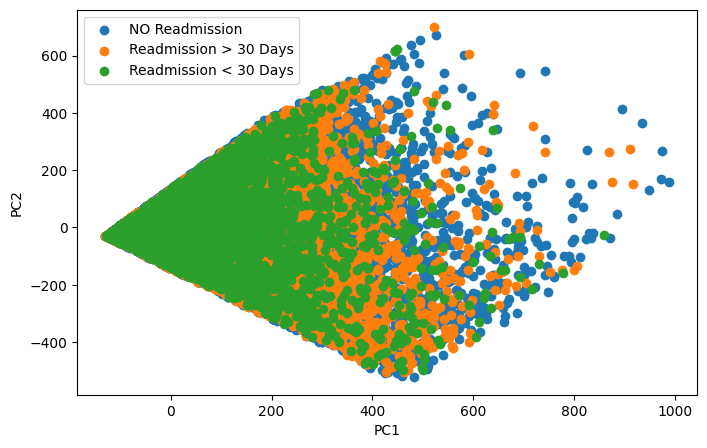

In [9]:
fig           = plt.figure(0, figsize = (8,5))
# ymax      = 50
# xmax      = 100

# Legend Won't Show Without Loop
target_classes = np.unique(target_factorized)
for label in target_classes:
  plt.scatter(x_pca[target_factorized==label, 0], \
              x_pca[target_factorized==label, 1], label = label)
  
  # plt.xlim([0, xmax])
  # plt.ylim([-ymax, ymax])

admission_titles = ['NO Readmission', 'Readmission > 30 Days', 'Readmission < 30 Days']
plt.legend(admission_titles)
plt.ylabel('PC2')
plt.xlabel('PC1')

**Plotting Seperately**

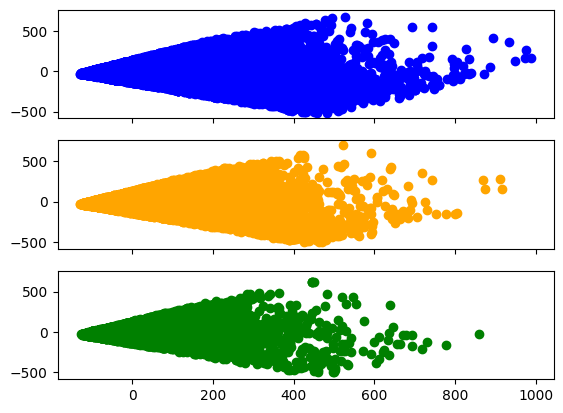

In [10]:
fig, ax = plt.subplots(3, sharey = True, sharex = True)

ax[0].scatter(x_pca[target_factorized == target_classes[0],0], \
              x_pca[target_factorized == target_classes[0], 1], \
              label = target_classes[0], color = ['blue'])

ax[1].scatter(x_pca[target_factorized == target_classes[1], 0], \
              x_pca[target_factorized == target_classes[1], 1], \
              label = target_classes[1], color = ['orange'])

ax[2].scatter(x_pca[target_factorized == target_classes[2], 0], \
              x_pca[target_factorized == target_classes[2], 1],\
              label = target_classes[1], color = ['green'])


**Feature Selection**

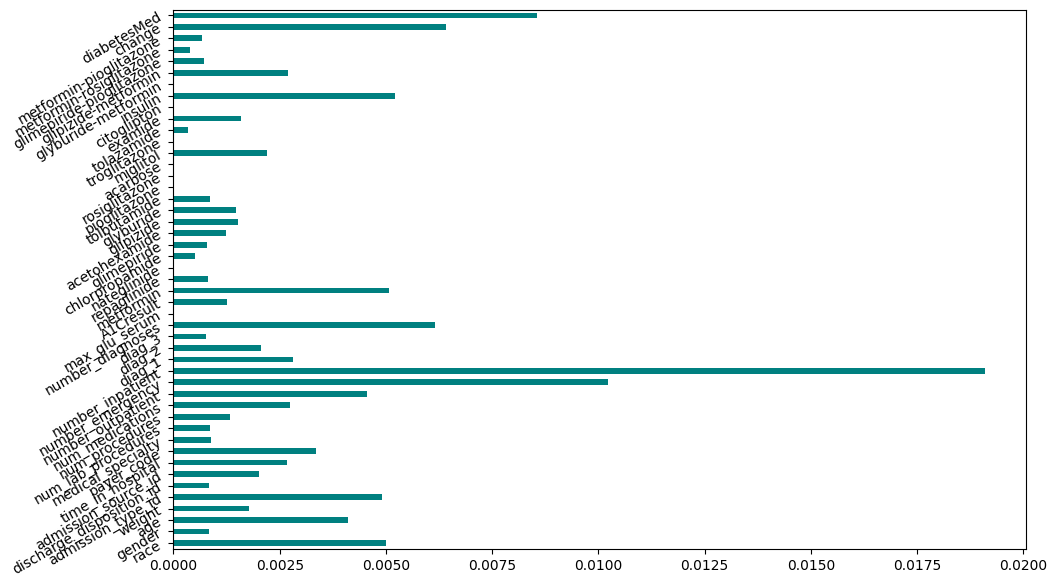

In [12]:
from   sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

fig              = plt.figure(figsize = (11, 7))
importances      = mutual_info_classif(x_training, target_factorized)
feat_importances = pd.Series(importances, x_training.columns[:len(x_training.columns)])
feat_importances.plot(kind='barh', color = 'teal')
plt.yticks(rotation = 30)
plt.show()

**Variables That Seem To Be Important from Mutual Class Info Test**
1. Number of Inpatient (visits to hospital)
2. Diabetes Medication (Taking Meds Yes or No)
3. Number of Emergency
4. Change
5. Gender
6. Discharge Disposition ID


**Pearson's Correlation Coefficient**

<Axes: >

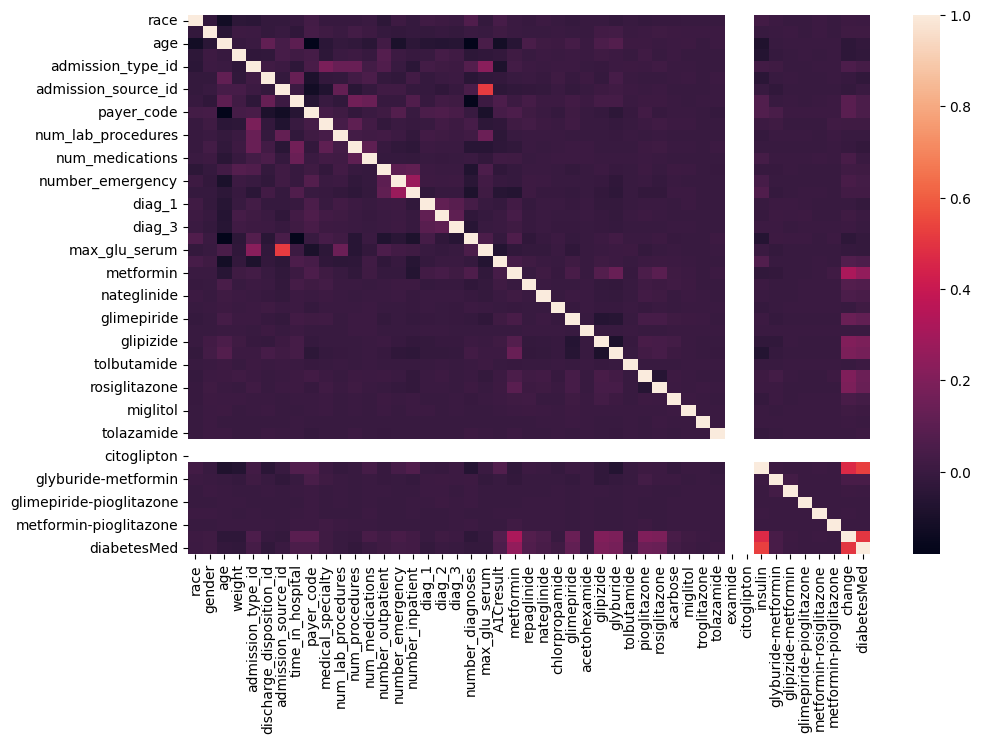

In [13]:
hmap_figure = plt.figure(figsize = (11, 7))
sns.heatmap(x_training.corr())

**Fischer's Score**

In [14]:
!pip install skfeature-chappers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.6 MB/s eta 0:00:00


In [ ]:
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt

# Calculating scores
ranks            = fisher_score.fisher_score(x_training, target_factorized) # plot the ranks
feat_importances = pd.Series(ranks, x_training.columns)
feat_importances.plot(kind='barh', color = 'teal')
plt.show()

**Checking High Variance Variables before Discretization**
1. Variance Threshold = 1 produces ~ 58% accuracy
2. All Features produces ~ 55%
3. Variance Treshold  = 2 produces ~ 56% accuracy
4. Variance Threshold = 3 produces ~ 55% accuracy
5. Variance Threshold = 0.5 produces ~ 59% accuracy
6. Variance Threshold = 0 produces ~ 59% accuracy 

**Variables That Could Be Descritized**
1. Discharge Disposition ID(Depending on meaning) (30 max)
2. Time in hospital (15 max)
3. Num Lab Procedures (130 max)
4. Num Medications (80 max)
5. Number outpateints and inpatinet

Text(0.5, 0, 'Unique Values')

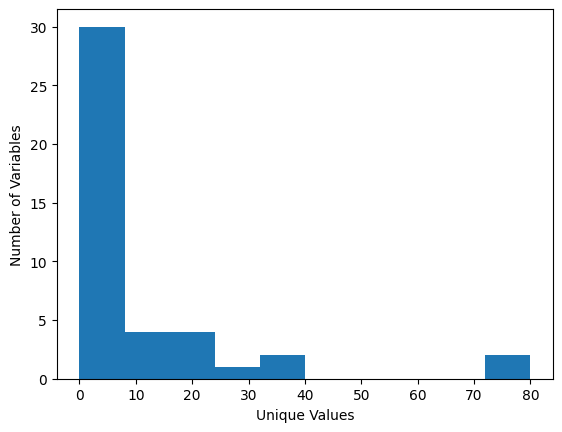

In [11]:
unique_variables = [len(x_data[col].unique()) for col in x_data.columns]
plt.hist(unique_variables, range = (0,80), bins = 10)
plt.ylabel('Number of Variables')
plt.xlabel('Unique Values')

In [ ]:
[x_training[col].unique() for col in x_training]

In [13]:
from sklearn.feature_selection import VarianceThreshold
# Resetting the value of X to make it non-categorical
# X = array[:, 0:8]

variance    = 0.5 
v_threshold = VarianceThreshold(threshold = variance) 
v_threshold.fit(x_training) # fit finds the features with zero variance
x_train_thresh = v_threshold.transform(x_training)
x_train_thresh = pd.DataFrame(x_train_thresh)

index_columns = [index for index in range(len(v_threshold.get_support())) if v_threshold.get_support()[index] == True]
column_names  = []
for index in index_columns:
  column_names.append(x_training.columns[index])

x_train_thresh.columns = column_names
x_train_thresh

,race,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,insulin
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,1,1,0,1,0,0,0,1,1,1,1,0,1
2,1,2,1,1,1,2,0,1,2,1,2,1,0,1,2,2,2,2,0,0
3,0,3,1,1,1,2,0,1,3,2,3,0,0,0,3,3,3,3,0,1
4,0,4,1,1,1,0,0,1,4,0,4,0,0,0,4,4,4,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,7,1,2,1,1,1,1,4,0,3,0,0,0,66,323,112,1,2,3
101762,1,8,1,9,4,4,1,1,9,5,1,0,0,1,71,29,109,1,0,2
101763,0,7,1,1,1,0,1,1,25,0,20,2,0,0,55,176,77,11,0,3
101764,0,8,2,2,1,9,1,5,16,4,5,0,0,1,22,53,29,1,0,1


**Discretize in Bins**

In [14]:
from sklearn.preprocessing import KBinsDiscretizer
import math

time_in_hosp        = 5
bin_size            = 10
descritized_columns = ['num_lab_procedures', 'num_procedures', 'time_in_hospital']
for col in descritized_columns:
  if col != 'time_in_hospital':
    for index in x_train_thresh.index:
      x_train_thresh.loc[index, col] = math.floor(x_train_thresh.loc[index, col] / bin_size) * bin_size
  else:
    for index in x_train_thresh.index:
      x_train_thresh.loc[index, col] = math.floor(x_train_thresh.loc[index, col] / time_in_hosp) * time_in_hosp
  

In [62]:
option            = ['fishers', 'mutual_class_info']
choice            = option[0]
if choice == option[0]:
  x_feature_selected = x_train_thresh
elif choice == option[1]:
  features_selected = ['number_inpatient', 'diabetesMed', 'number_emergency',
                      'change', 'gender', 'discharge_disposition_id']
  x_feature_selected = x_training[features_selected]

x_train, x_test, y_train, y_test = train_test_split(x_feature_selected, target_factorized, test_size = 0.2, shuffle = True)
x_train, x_val, y_train, y_val   = train_test_split(x_train, y_train, test_size = 0.15, shuffle = True)

**Random Forest Classifier**

In [16]:
random_forest = RandomForestClassifier(n_estimators = 100, verbose = True)
random_forest.fit(x_train, y_train)

predictions = random_forest.predict(x_test)
accuracy_score(predictions, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


0.579836887098359

**XGBoost Model**
Regularization (overfitting prevention) Parameters:
1. Sub Sample (0.1-1)
2. Cal Sample by Level (0.1-1)
3. Cal Sample by Tree (0.1-1)
4. Min-childweight
5. lambda-yalp

In [17]:
if binary_targets:
  objective = 'binary:logistic'
else:
  objective = 'multi:softmax'

xgb_model         = xgb.XGBClassifier(n_estimators = 50, learning_rate = 0.1, 
                              objective   = objective,
                              min_child_weight = 0, reg_alpha = 20, reg_lambda = 35)
                              
model_fits        = xgb_model.fit(x_train, y_train, 
                    eval_set = [(x_train, y_train),(x_val, y_val)], 
                    verbose = False)

xgb_predictions   = xgb_model.predict(x_test)
accuracies        = [accuracy_score(y_test, xgb_predictions)]
accuracy_score(y_test, xgb_predictions) 

0.5862238380662278

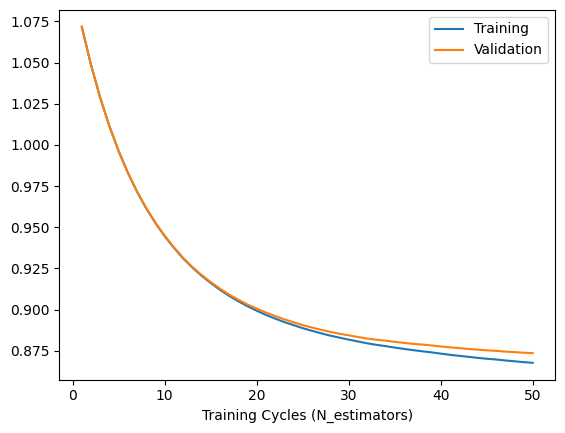

In [18]:
loss                = xgb_model.evals_result()
training_loss       = dict(loss['validation_0'])['mlogloss']
validation_loss     = dict(loss['validation_1'])['mlogloss']

plt.plot(range(1, len(training_loss)+1), training_loss, label = 'Training')
plt.plot(range(1, len(validation_loss)+1), validation_loss, label = 'Validation')
plt.xlabel('Training Cycles (N_estimators)')
plt.legend()

**Hyperparameter Optimization**

In [19]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
reduced_length = 5000 # For Computing Reasons (On Faster Computer can remove this)
x_train_red = x_train[0:reduced_length]
y_train_red = y_train[0:reduced_length]

# output of function needs to minimzied
# for a classification problem, were minimizing the accuracy
# so in theory, it's really just having a metric that calculates the accuracy
# then that accuracy is being maximzied in a bayesian fassion
def bayes_opt(n_estimators, subsample, learning_rate, max_depth, colsample_bytree, eta):

  folds     = 5
  skf       = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

  params_gbm                     = {}
  params_gbm['learning_rate']    = learning_rate
  params_gbm['n_estimators']     = int(n_estimators)
  # params_gbm['reg_lambda']       = reg_lambda
  # params_gbm['reg_alpha']        = reg_alpha
  # params_gbm['gamma']            = round(gamma)
  params_gbm['subsample']        = subsample
  params_gbm['max_depth']        = int(max_depth)
  params_gbm['colsample_bytree'] = colsample_bytree
  params_gbm['eta']              = eta


  weights      = class_weight.compute_sample_weight('balanced', y_train)

  scores       = []
  for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_red, y_train_red)):
  
    x_train_fold, y_train_fold = pd.DataFrame(x_train_red).iloc[train_idx], pd.DataFrame(y_train_red).iloc[train_idx]
    x_val, y_val = pd.DataFrame(x_train_red).iloc[val_idx], pd.DataFrame(y_train_red).iloc[val_idx]
    watchlist = [(x_train_fold, y_train_fold), (x_val, y_val)]
    
    scorer     = make_scorer(log_loss)
    
    xgb_model  = XGBClassifier(**params_gbm, 
                               objective = 'multi:softmax', 
                               eval_metric = 'mlogloss')
    
    xgb_model.fit(x_train_fold, y_train_fold)
    
    val_preds  = xgb_model.predict_proba(x_val)
    score      = log_loss(y_val, val_preds)  
    scores.append(score)



  scores = np.average(scores)


  # maximize 1- logloss (minimize logloss)

  return 1 - scores



pbounds = {'n_estimators': (100, 500),
          'subsample': (0.6, 1.0),
          'learning_rate':(0.01, 3),
           'max_depth': (3, 10),
           'colsample_bytree': (0.5, 1),
           'eta': (0.2, 0.4)
          }

optimizer   = BayesianOptimization(
    f       = bayes_opt,
    pbounds = pbounds,
    verbose = 2
)

In [50]:
optimizations = optimizer.maximize(
    init_points=4,
    n_iter=100,
)

|   iter    |  target   | colsam... |    eta    | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.2641   | 0.8004    | 0.3716    | 0.2556    | 6.523     | 305.5     | 0.6917    |
| 2         | -1.345    | 0.8081    | 0.3083    | 1.876     | 7.231     | 247.1     | 0.8428    |
| 3         | -8.247    | 0.542     | 0.3257    | 2.825     | 4.135     | 467.7     | 0.8101    |
| 4         | -1.236    | 0.8911    | 0.2262    | 1.525     | 4.688     | 408.7     | 0.8584    |
| 5         | -1.557    | 0.6419    | 0.3253    | 1.673     | 6.312     | 305.2     | 0.6565    |
| 6         | -0.4802   | 0.5849    | 0.3743    | 0.4168    | 8.307     | 310.9     | 0.9175    |
| 7         | 0.1051    | 1.0       | 0.4       | 0.01      | 3.0       | 316.3     | 0.6       |
| 8         | 0.1043    | 1.0       | 0.4       | 0.01      | 8.896     | 321.2     | 0.6       |
| 9         | -1.224

In [64]:
xgb_model  = XGBClassifier(colsample_bytree = 1, learning_rate = 0.01, eta = 0.4,
                           max_depth = 5, n_estimators = 493, subsample = 0.6,
                           objective = 'multi:softmax', eval_metric = 'mlogloss')

In [65]:
xgb_model.fit(x_train, y_train)
predictions = xgb_model.predict(x_test)
accuracy_score(predictions, y_test)

0.5845042743441092

**SMAC always minimized target function (train return statement)**

In [ ]:
!pip install smac

In [ ]:
from xgboost.sklearn import XGBClassifier
from ConfigSpace import Configuration, ConfigurationSpace

import numpy as np
from smac import HyperparameterOptimizationFacade, Scenario

def train(config: Configuration, seed: int = 0) -> float:
    classifier = XGBClassifier(n_estimators = config['estimators'], random_state=seed, 
                               reg_alpha = config['reg_alpha'], objective = 'multi:softmax',
                               reg_lambda = config['reg_lambda'], learning_rate = config['lr'])
    print('hello')

    # scores = cross_val_score(classifier, x_data, target_factorized, cv=5)
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    accuracy    = accuracy_score(predictions, y_test)
    return 1 - accuracy

configspace = ConfigurationSpace({"estimators": (50, 150), 
                                  'reg_alpha': (0, 100),
                                  'reg_lambda': (0, 100), 
                                  'lr': (0, 1)})

# Scenario object specifying the optimization environment
scenario = Scenario(configspace, deterministic=True, n_trials=25, walltime_limit=600)

# Use SMAC to find the best configuration/hyperparameters
smac      = HyperparameterOptimizationFacade(scenario, train)
incumbent = smac.optimize()


[INFO][abstract_initial_design.py:82] Reducing the number of initial configurations from 40 to 6 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:134] Using 6 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
hello
[INFO][abstract_intensifier.py:513] Added config 200eab as new incumbent because there are no incumbents yet.
hello
hello
[INFO][abstract_intensifier.py:588] Added config 705ec3 and rejected config 200eab as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- estimators: 76 -> 109
[INFO][configspace.py:175] --- reg_alpha: 10 -> 28
[INFO][configspace.py:175] --- reg_lambda: 21 -> 49
hello
hello
hello
hello
[INFO][abstract_intensifier.py:588] Added config b0f41f and rejected config 705ec3 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- estimators: 109 -> 86
[INFO][config

In [ ]:
classifier = XGBClassifier(n_estimators = 133, random_state = 0, 
                               reg_alpha = 22, objective = 'multi:softmax',
                               reg_lambda = 51, learning_rate = 1)
    
# scores = cross_val_score(classifier, x_data, target_factorized, cv=5)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)
accuracy = accuracy_score(predictions, y_test)
accuracy